# YOLO-World zero shot model for object detection
This model is pretrained as a very large model that can identify many objects and classes without explicit training by the user. In this notebook we look at the efficacy of the model in identifying different types of bees without explicit training.

In [1]:
from ultralytics import YOLO
import cv2
from IPython.display import Image

model_path = "yolov8x-worldv2.pt"
image_path = "media/mosaic_1.jpg"
output_image_path = "media/mosaic_1_yolo_world_results.jpg"

frame = cv2.imread(image_path)
model = YOLO(model_path)
model.set_classes(
    [
        "Allodapula",
        "Apis-mellifera-scutellata",
        "Braunsapis",
        "Lasioglossum",
        "Meliponula",
        "Seladonia",
        "Thyreus",
        "Xylocopa",
    ]
)
yolo_detections = model.predict(
    frame,
    iou=0.3,
    agnostic_nms=True,
    conf=0.05,
)


0: 480x640 1 Allodapula, 8 Lasioglossums, 1 Xylocopa, 544.2ms
Speed: 3.8ms preprocess, 544.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


## Create some functions

In [2]:
def format_yolo_detections(yolo_detections):
    detected = list(
        zip(
            yolo_detections[0].boxes.xywhn,
            yolo_detections[0].boxes.conf,
            yolo_detections[0].boxes.cls,
        )
    )

    formatted_yolo = []
    for det in detected:
        new_det = []
        for tensor in det:
            try:
                for val in tensor:
                    new_det.append(float(val))
            except TypeError:
                new_det.append(float(tensor))
        formatted_yolo.append(new_det)

    for det in formatted_yolo:
        det[5] = int(det[5])

    return formatted_yolo


def write_frame_with_detections(frame, yolo_detections, model):
    """
    Shows the current frame with bboxes drawn on it
    """
    boxed_frame = frame.copy()
    formatted_detections = format_yolo_detections(yolo_detections)
    for x, y, w, h, conf, label in formatted_detections:
        label = int(label)
        w = w * boxed_frame.shape[1]
        h = h * boxed_frame.shape[0]
        x = x * boxed_frame.shape[1]
        y = y * boxed_frame.shape[0]
        x1 = int(x - w / 2)
        x2 = int(x + w / 2)
        y1 = int(y - h / 2)
        y2 = int(y + h / 2)

        using_color = (0, 255, 0)
        label_name = model.names[label]

        cv2.rectangle(boxed_frame, (x1, y1), (x2, y2), color=using_color, thickness=2)
        cv2.putText(
            boxed_frame,
            f"{label_name}-{int(conf*100)}%",
            (int(x1), int(y1 - 10)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.4,
            using_color,
            1,
        )

    cv2.imwrite(output_image_path, boxed_frame)
    return

## Display the prediction results

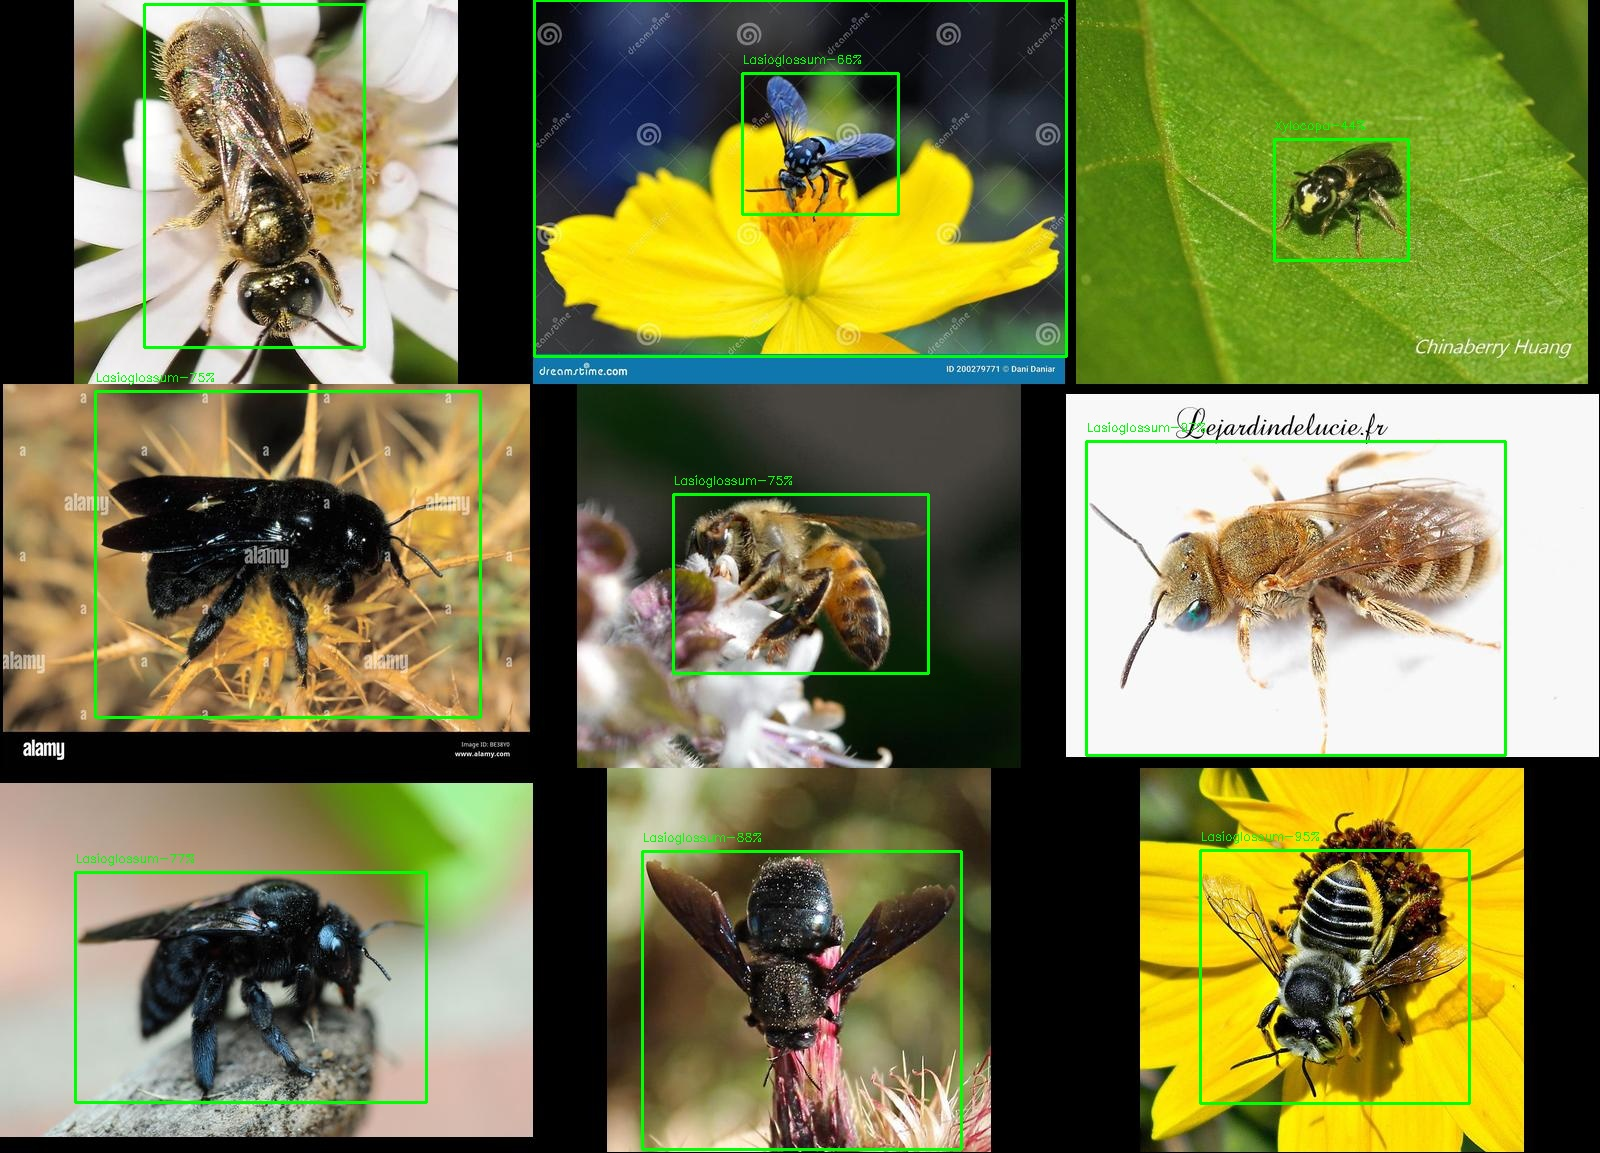

In [3]:
write_frame_with_detections(frame, yolo_detections, model)
Image(output_image_path)

## Results
Here we can see that the bees are all identified as "Lasioglossum" (except for one which is "Xyocopa") which is not correct. Therefore, this zero-shot model cannot work for identifying different types of bees.